# Store Item Demand Forecasting with Baseline XGBoost Regressor

## Import required libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import time

import warnings
warnings.filterwarnings("ignore")

import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
import pickle

## Read datasets

In [2]:
# google colab
from google.colab import drive
drive.mount('/content/drive')

train_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ml project/train.csv', parse_dates = ['date'])
test_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ml project/test.csv', parse_dates = ['date'])

Mounted at /content/drive


In [3]:
# # jupyter
# train_data = pd.read_csv('train.csv', parse_dates = ['date'])
# test_data = pd.read_csv('test.csv', parse_dates = ['date'])

In [4]:
train_data.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [5]:
test_data.head()

,id,date,store,item
0,0,2018-01-01,1,1
1,1,2018-01-02,1,1
2,2,2018-01-03,1,1
3,3,2018-01-04,1,1
4,4,2018-01-05,1,1


In [6]:
data = pd.concat([train_data, test_data],sort= False)

data

,date,store,item,sales,id
0,2013-01-01,1,1,13.0,NaN
1,2013-01-02,1,1,11.0,NaN
2,2013-01-03,1,1,14.0,NaN
3,2013-01-04,1,1,13.0,NaN
4,2013-01-05,1,1,10.0,NaN
...,...,...,...,...,...
44995,2018-03-27,10,50,NaN,44995.0
44996,2018-03-28,10,50,NaN,44996.0
44997,2018-03-29,10,50,NaN,44997.0
44998,2018-03-30,10,50,NaN,44998.0


## Data preprocessing

### Feature engineering

#### Datetime features

In [7]:
def create_date_time_features(df):
    df = df.copy()

    df['day_of_week'] = df.date.dt.dayofweek
    df['quarter'] = df.date.dt.quarter
    df['month'] = df.date.dt.month
    df['week_of_year'] = df.date.dt.isocalendar().week.astype("int64")

    return df

In [8]:
df1 = create_date_time_features(data)

df1.head()

,date,store,item,sales,id,day_of_week,quarter,month,week_of_year
0,2013-01-01,1,1,13.0,NaN,1,1,1,1
1,2013-01-02,1,1,11.0,NaN,2,1,1,1
2,2013-01-03,1,1,14.0,NaN,3,1,1,1
3,2013-01-04,1,1,13.0,NaN,4,1,1,1
4,2013-01-05,1,1,10.0,NaN,5,1,1,1


#### Lag features

In [9]:
def lag_features(df, lags):
    for lag in lags:
        df['sales_lag_' + str(lag)] = df.groupby(["store", "item"])['sales'].transform(lambda x: x.shift(lag))
    return df

In [10]:
df1 = lag_features(df1, [91, 98, 105, 112, 119, 126, 182, 364, 546, 728])

df1.head()

,date,store,item,sales,id,day_of_week,quarter,month,week_of_year,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_112,sales_lag_119,sales_lag_126,sales_lag_182,sales_lag_364,sales_lag_546,sales_lag_728
0,2013-01-01,1,1,13.0,NaN,1,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-01-02,1,1,11.0,NaN,2,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2013-01-03,1,1,14.0,NaN,3,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2013-01-04,1,1,13.0,NaN,4,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2013-01-05,1,1,10.0,NaN,5,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Rolling mean features

In [11]:
def roll_mean_features(df, windows):
    for window in windows:
        df['sales_roll_mean_' + str(window)] = df.groupby(["store", "item"])['sales']. \
                                             transform(lambda x: x.shift(1).rolling(window=window, min_periods=10, win_type="triang").mean())
    return df

In [12]:
df1 = roll_mean_features(df1, [365, 546])

df1.head()

,date,store,item,sales,id,day_of_week,quarter,month,week_of_year,sales_lag_91,...,sales_lag_105,sales_lag_112,sales_lag_119,sales_lag_126,sales_lag_182,sales_lag_364,sales_lag_546,sales_lag_728,sales_roll_mean_365,sales_roll_mean_546
0,2013-01-01,1,1,13.0,NaN,1,1,1,1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-01-02,1,1,11.0,NaN,2,1,1,1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2013-01-03,1,1,14.0,NaN,3,1,1,1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2013-01-04,1,1,13.0,NaN,4,1,1,1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2013-01-05,1,1,10.0,NaN,5,1,1,1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Exponentially weighted mean features

In [13]:
def ewm_features(dataframe, alphas, lags):
    for alpha in alphas:
        for lag in lags:
            dataframe['sales_ewm_alpha_' + str(alpha).replace(".", "") + "_lag_" + str(lag)] = \
                dataframe.groupby(["store", "item"])['sales'].transform(lambda x: x.shift(lag).ewm(alpha=alpha).mean())
    return dataframe

In [14]:
alphas = [0.95, 0.9, 0.8, 0.7, 0.5]
lags   = [91, 98, 105, 112, 180, 270, 365, 546, 728]

In [15]:
df1 = ewm_features(df1, alphas, lags)

df1.head()

,date,store,item,sales,id,day_of_week,quarter,month,week_of_year,sales_lag_91,...,sales_ewm_alpha_07_lag_728,sales_ewm_alpha_05_lag_91,sales_ewm_alpha_05_lag_98,sales_ewm_alpha_05_lag_105,sales_ewm_alpha_05_lag_112,sales_ewm_alpha_05_lag_180,sales_ewm_alpha_05_lag_270,sales_ewm_alpha_05_lag_365,sales_ewm_alpha_05_lag_546,sales_ewm_alpha_05_lag_728
0,2013-01-01,1,1,13.0,NaN,1,1,1,1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-01-02,1,1,11.0,NaN,2,1,1,1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2013-01-03,1,1,14.0,NaN,3,1,1,1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2013-01-04,1,1,13.0,NaN,4,1,1,1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2013-01-05,1,1,10.0,NaN,5,1,1,1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Summary

In [16]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 958000 entries, 0 to 44999
Data columns (total 66 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   date                         958000 non-null  datetime64[ns]
 1   store                        958000 non-null  int64         
 2   item                         958000 non-null  int64         
 3   sales                        913000 non-null  float64       
 4   id                           45000 non-null   float64       
 5   day_of_week                  958000 non-null  int64         
 6   quarter                      958000 non-null  int64         
 7   month                        958000 non-null  int64         
 8   week_of_year                 958000 non-null  int64         
 9   sales_lag_91                 912500 non-null  float64       
 10  sales_lag_98                 909000 non-null  float64       
 11  sales_lag_105              

### One-Hot-Encoding

In [17]:
df2 = pd.get_dummies(df1, columns=['store', 'item', 'month', 'week_of_year' , 'day_of_week', "quarter"])

df2.shape

(958000, 196)

### Logarithmic Transformation for Sales data

Logarithmic transformation is a convenient means of transforming a skewed variable into a more normalized dataset. When modeling variables with non-linear relationships, the chances of producing errors may also be skewed negatively

In theory, we want to produce the smallest error possible when making a prediction, while also taking into account that we should not be overfitting the model. Overfitting occurs when there are too many dependent variables in play that it does not have enough generalization of the dataset to make a valid prediction. Using the logarithm of one or more variables improves the fit of the model by transforming the distribution of the features to a more normally-shaped bell curve.
[source](https://dev.to/rokaandy/logarithmic-transformation-in-linear-regression-models-why-when-3a7c#:~:text=The%20Why%3A,may%20also%20be%20skewed%20negatively.)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f227c394bd0>]],
      dtype=object)

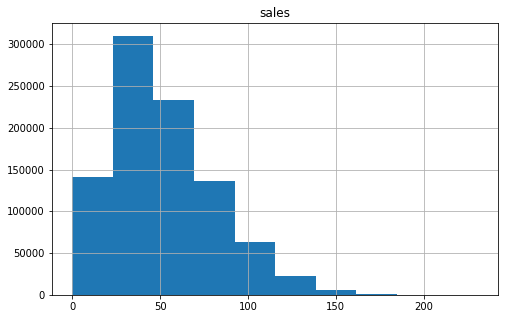

In [18]:
# original
df2.hist('sales',figsize=(8,5))

In [19]:
df2['sales']= np.log1p(df2["sales"].values)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f227c37ab50>]],
      dtype=object)

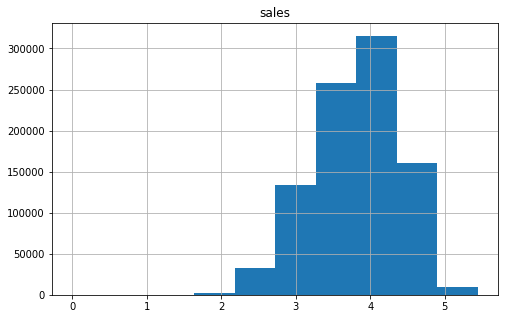

In [20]:
# transformed
df2.hist('sales',figsize=(8,5))

### Split into train val test

* train: 2013 to 2016 (4 years) - 80%
* val: 2017 (1 year) - 20%
* test: 2018 onwards

In [21]:
df_model = df2.copy()

In [22]:
df_model = df_model.sort_values("date").reset_index(drop = True)

In [23]:
train = df_model.loc[(df_model["date"] < "2017-01-01"), :]

val = df_model.loc[(df_model["date"] >= "2017-01-01") & (df_model["date"] < "2017-04-01"), :]

In [24]:
train.head()

,date,sales,id,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_112,sales_lag_119,sales_lag_126,sales_lag_182,...,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,quarter_1,quarter_2,quarter_3,quarter_4
0,2013-01-01,2.639057,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1,0,0,0,0,0,1,0,0,0
1,2013-01-01,2.833213,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1,0,0,0,0,0,1,0,0,0
2,2013-01-01,3.044522,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1,0,0,0,0,0,1,0,0,0
3,2013-01-01,3.555348,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1,0,0,0,0,0,1,0,0,0
4,2013-01-01,2.995732,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1,0,0,0,0,0,1,0,0,0


In [25]:
val.head()

,date,sales,id,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_112,sales_lag_119,sales_lag_126,sales_lag_182,...,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,quarter_1,quarter_2,quarter_3,quarter_4
730500,2017-01-01,3.663562,NaN,49.0,59.0,43.0,50.0,45.0,62.0,78.0,...,0,0,0,0,0,1,1,0,0,0
730501,2017-01-01,4.682131,NaN,131.0,167.0,142.0,145.0,159.0,171.0,189.0,...,0,0,0,0,0,1,1,0,0,0
730502,2017-01-01,4.077537,NaN,69.0,84.0,92.0,86.0,109.0,90.0,110.0,...,0,0,0,0,0,1,1,0,0,0
730503,2017-01-01,3.295837,NaN,40.0,34.0,33.0,33.0,34.0,44.0,39.0,...,0,0,0,0,0,1,1,0,0,0
730504,2017-01-01,3.367296,NaN,38.0,37.0,55.0,42.0,41.0,52.0,43.0,...,0,0,0,0,0,1,1,0,0,0


In [26]:
cols = [col for col in train.columns if col not in ['date', 'id', "sales"]]

In [27]:
X_train = train[cols]
Y_train = train['sales']

X_train.shape, Y_train.shape

((730500, 193), (730500,))

In [28]:
X_val = val[cols]
Y_val = val['sales']

X_val.shape, Y_val.shape

((45000, 193), (45000,))

## XGBoost regressor

In [29]:
model= xgb.XGBRegressor()

In [30]:
# get baseline model parameters
model.get_params()

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'importance_type': 'gain',
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 3,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 100,
 'n_jobs': 1,
 'nthread': None,
 'objective': 'reg:linear',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': None,
 'silent': None,
 'subsample': 1,
 'verbosity': 1}

In [31]:
t0 = time.time()

first_model = model.fit(X_train, Y_train, 
                       eval_set=[(X_val, Y_val)],
                       early_stopping_rounds=10)

t1 = time.time()
train_time = t1 - t0

[15:11:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:2.91846
Will train until validation_0-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:2.61754
[2]	validation_0-rmse:2.34683
[3]	validation_0-rmse:2.10497
[4]	validation_0-rmse:1.88491
[5]	validation_0-rmse:1.69012
[6]	validation_0-rmse:1.51488
[7]	validation_0-rmse:1.35633
[8]	validation_0-rmse:1.21583
[9]	validation_0-rmse:1.08955
[10]	validation_0-rmse:0.974499
[11]	validation_0-rmse:0.873463
[12]	validation_0-rmse:0.784606
[13]	validation_0-rmse:0.702009
[14]	validation_0-rmse:0.633811
[15]	validation_0-rmse:0.568775
[16]	validation_0-rmse:0.513372
[17]	validation_0-rmse:0.462927
[18]	validation_0-rmse:0.419392
[19]	validation_0-rmse:0.380208
[20]	validation_0-rmse:0.349624
[21]	validation_0-rmse:0.321793
[22]	validation_0-rmse:0.296243
[23]	validation_0-rmse:0.275656
[24]	validation_0-rmse:0.261803
[25]	validation_0-rmse:0.247

In [32]:
# pickling the model
pickle.dump(first_model, open('xgboost-base_regressor.sav', 'wb'))

## Model evaluation

In [33]:
# define smape metric
def smape(preds, target):
    n = len(preds)
    masked_arr = ~((preds == 0) & (target == 0))
    preds, target = preds[masked_arr], target[masked_arr]
    num = np.abs(preds-target)
    denom = np.abs(preds)+np.abs(target)
    smape_val = (200*np.sum(num/denom))/n
    return smape_val

def xgb_smape(y_pred, y_true):
    smape_val = smape(np.expm1(y_pred), np.expm1(y_true))
    return 'SMAPE', smape_val, False

In [34]:
print("SMAPE:", smape(np.expm1(first_model.predict(X_val)), np.expm1(Y_val)))
print("\nMean squared error (MSE):", mean_squared_error(Y_val, first_model.predict(X_val)))
print("\nR2 score:", r2_score(Y_val, first_model.predict(X_val)))
print("\nTraining time: %fs" % (train_time))

SMAPE: 14.365546905075893

Mean squared error (MSE): 0.03351967260630963

R2 score: 0.8894704233875294

Training time: 600.799182s


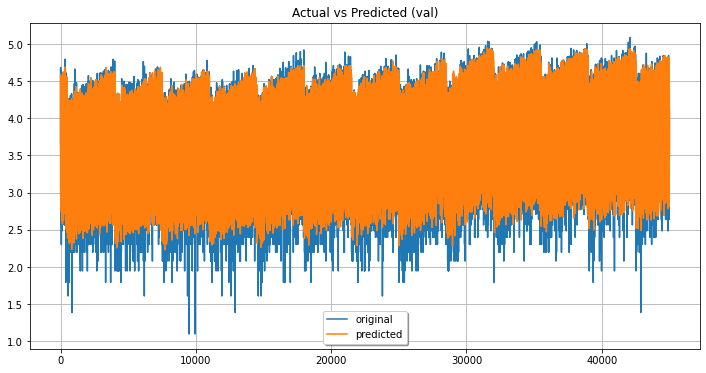

In [35]:
# visualize results
x_ax = range(len(Y_val))
plt.figure(figsize=(12, 6))
plt.plot(x_ax, Y_val, label="original")
plt.plot(x_ax, first_model.predict(X_val), label="predicted")
plt.title("Actual vs Predicted (val)")
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.show()

## Feature importance

In [36]:
feature_importance = pd.DataFrame(data   = first_model.feature_importances_,
                 index  = first_model.get_booster().feature_names,
                 columns = ['importance'])

# top 20
feature_importance.sort_values('importance', ascending=False).head(20)

,importance
sales_roll_mean_546,0.236525
sales_lag_91,0.161388
sales_lag_98,0.064833
sales_lag_364,0.060989
sales_ewm_alpha_095_lag_365,0.038417
quarter_2,0.031756
sales_ewm_alpha_09_lag_728,0.031429
quarter_3,0.028511
sales_ewm_alpha_05_lag_365,0.027296
sales_ewm_alpha_09_lag_365,0.023668


<Figure size 2160x720 with 0 Axes>

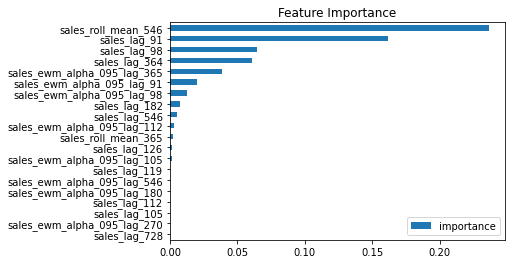

In [37]:
plt.figure(figsize=(30, 10))
feature_importance.head(20).sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.legend(loc='lower right')
plt.show()

In [38]:
feature_importance.to_csv('xgboost_base-feature_importance.csv', index=False)

## Predict on test

In [39]:
df_final_model = df2.copy()
test = df_final_model.loc[df_final_model.sales.isna()]
X_test = test[cols]

In [40]:
X_test.head()

,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_112,sales_lag_119,sales_lag_126,sales_lag_182,sales_lag_364,sales_lag_546,sales_lag_728,...,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,quarter_1,quarter_2,quarter_3,quarter_4
0,12.0,14.0,22.0,16.0,12.0,15.0,18.0,15.0,18.0,12.0,...,0,0,0,0,0,0,1,0,0,0
1,18.0,18.0,21.0,20.0,26.0,21.0,23.0,10.0,31.0,12.0,...,1,0,0,0,0,0,1,0,0,0
2,15.0,27.0,20.0,13.0,24.0,22.0,23.0,16.0,22.0,16.0,...,0,1,0,0,0,0,1,0,0,0
3,20.0,23.0,20.0,26.0,29.0,26.0,31.0,14.0,33.0,12.0,...,0,0,1,0,0,0,1,0,0,0
4,19.0,28.0,28.0,28.0,28.0,38.0,32.0,24.0,34.0,12.0,...,0,0,0,1,0,0,1,0,0,0


In [41]:
test_preds = first_model.predict(X_test)

test_preds

array([2.6467915, 2.743594 , 2.7456706, ..., 4.320942 , 4.4303226,
       4.579922 ], dtype=float32)

In [42]:
submission_df = test.loc[:, ['id', 'sales']]
submission_df['sales'] = np.expm1(test_preds)
submission_df['id'] = submission_df.id.astype(int)
submission_df['sales'] = submission_df.sales.astype(int)

submission_df.head()

,id,sales
0,0,13
1,1,14
2,2,14
3,3,15
4,4,17


In [43]:
submission_df.to_csv('xgboost-base_submission.csv', index=False)